In [1]:
# first we define the simulator and setup a quantum instance
import qiskit
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

In [2]:
# then we setup our ansatz for the wavefunction

from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(2, reps=1)
print(type(ansatz))
print(ansatz)
ansatz.draw(style='mpl')

<class 'qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes'>
     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘


┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘

In [3]:
ansatz = RealAmplitudes(3, reps=1)
from qiskit import QuantumCircuit
qc=QuantumCircuit(3)
qc.compose(ansatz,inplace=True)
print(ansatz)


     ┌────────────────────────────────────────────────┐
q_0: ┤0                                               ├
     │                                                │
q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├
     │                                                │
q_2: ┤2                                               ├
     └────────────────────────────────────────────────┘


In [4]:
# now we have to define the observable we want the minimum eigenvalue of
from qiskit.opflow import X,Y,Z,I

observable = Z^I

In [5]:
# set-up the vqe algorithm, with an optimizer and wave function
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
type(vqe)

qiskit.algorithms.minimum_eigen_solvers.vqe.VQE

In [6]:
# we could run this for many observables
result = vqe.compute_minimum_eigenvalue(observable)
print(type(result))
print(result.eigenvalue)

<class 'qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult'>
(-0.9999999788801595+0j)


In [7]:
# now we have to define the observable we want the minimum eigenvalue of
from qiskit.opflow import X,Y,Z,I,H

observable = Y^I

result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

0j


In [8]:
#result.eigenvector
vqe.get_optimal_vector()

/tmp/ipykernel_64388/1052005042.py:2: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  vqe.get_optimal_vector()


array([ 0.53494358+0.j,  0.33177639+0.j,  0.7448755 +0.j, -0.22117931+0.j])

In [9]:
import numpy as np
np.linalg.eig(observable.to_matrix())

(array([ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j]),
 array([[-0.        -0.70710678j,  0.70710678+0.j        ,
          0.        +0.j        ,  0.        -0.j        ],
        [-0.        +0.j        ,  0.        +0.j        ,
          0.        -0.70710678j,  0.70710678+0.j        ],
        [ 0.70710678+0.j        ,  0.        -0.70710678j,
          0.        +0.j        ,  0.        -0.j        ],
        [-0.        +0.j        ,  0.        +0.j        ,
          0.70710678+0.j        ,  0.        -0.70710678j]]))

## Lets try it for the HO, should get eigenvalue 0

In [10]:
import sys
sys.path.append('..')
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

In [11]:
h_b_HO = 0.5*(p*p + m*m*q*q)
h_f_HO = -0.5*m#[bdag,b]

powersof2=[2**n for n in range(1,3)]

HOhams = []
for n in powersof2:
    HOhams.append({'n': n, 'ham': Hamiltonian(h_b_HO, h_f_HO, {m:1, g:1},
                  n, standard_encode)})

In [12]:
for sys in HOhams:
    obsHOHAM = pauli_string_to_op(sys['ham'].pauliStrings)
    result = vqe.compute_minimum_eigenvalue(obsHOHAM)
    #print(result.eigenvalue)
    sys['vqe']=result.eigenvalue
    
    eigSys = np.linalg.eig(np.array(sys['ham'].hamMatrix,dtype=float))
    eigVals = [en.real for en in eigSys[0]]    
    sys['exact']=np.min(np.sort(eigVals))

In [13]:
#ovec=vqe.get_optimal_vector()
#svec=qiskit.quantum_info.Statevector(ovec)
#svec.probabilities_dict()

# this will be deprecated soon

In [14]:
def fill_vqe_dict(h_b,h_f,params,sizes):
    res = []
    for n in sizes:
        res.append({'n': n, 'ham': Hamiltonian(h_b, h_f, params, n, standard_encode)})
        
    for sys in res:
        ham = pauli_string_to_op(sys['ham'].pauliStrings)
        results=[]
        for i in range(100):
            results.append(vqe.compute_minimum_eigenvalue(ham).eigenvalue)
        #print(results)
        sys['vqe']=np.array(results).min()
    
        eigSys = np.linalg.eig(np.array(sys['ham'].hamMatrix,dtype=float))
        eigVals = [en.real for en in eigSys[0]]    
        sys['exact']=np.min(np.sort(eigVals))
        
    return res

In [15]:
def latex_vqe_table(data):
    s=''
    for d in data:
        s+="{} & {:.2e} & {:.2e} \\\\ \n".format(d['n'],d['exact'],d['vqe'].real)
    return s

In [16]:
ho_data=fill_vqe_dict(h_b_HO,h_f_HO,{m:1, g:1},[2**i for i in range(1,4)])
print(latex_vqe_table(ho_data))

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

### HO Ground State Fidelity

In [ ]:
h_b_HO = 0.5*(p*p + m*m*q*q)
h_f_HO = -0.5*m#[bdag,b]

HOham=Hamiltonian(h_b_HO, h_f_HO, {m:1, g:1},
                  2**2, standard_encode)
obsHOHAM = pauli_string_to_op(HOham.pauliStrings)
result = vqe.compute_minimum_eigenvalue(obsHOHAM)

In [17]:
vqe.get_optimal_vector()

/tmp/ipykernel_64388/843297991.py:1: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  vqe.get_optimal_vector()


array([ 4.89284721e-05+0.j, -9.99999997e-01+0.j,  3.47372441e-05+0.j,
       -4.95357810e-05+0.j,  5.31404263e-10+0.j, -2.33591603e-05-0.j,
       -5.01128091e-11+0.j,  1.76043396e-05+0.j])

In [ ]:
0000,0001,0010,0011...

In [ ]:
np.linalg.eig(np.array(HOham.hamMatrix,dtype=float))

## AHO

In [15]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

In [16]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**2, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([ 0.12682403,  2.08341082,  3.323419  ,  7.31797807, 32.24817597,
       41.29158918, 81.301581  , 94.30702193])

In [18]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**3, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([2.92568799e-02, 1.70677100e+00, 1.78275273e+00, 4.73407590e+00,
       7.22350860e+00, 1.24381795e+01, 1.84881706e+01, 2.61305422e+01,
       7.21041337e+01, 8.49087650e+01])

In [19]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**4, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([1.83029849e-03, 1.68720122e+00, 1.70732190e+00, 4.37401524e+00,
       4.41418952e+00, 7.76596507e+00, 7.94769938e+00, 1.23737466e+01,
       1.55392089e+01, 2.23264623e+01])

In [20]:
ho_data=fill_vqe_dict(h_b_AHO,h_f_AHO, {m:1, g:1},[2**i for i in range(1,4)])
print(latex_vqe_table(ho_data))

2 & 9.38e-01 & 9.38e-01 \\ 
4 & 1.27e-01 & 1.27e-01 \\ 
8 & 2.93e-02 & 2.93e-02 \\ 



### AHO Fidelity

In [24]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

AHOham=Hamiltonian(h_b_AHO, h_f_AHO, {m:1, g:1},
                  2**2, standard_encode)

obsAHOHAM = pauli_string_to_op(AHOham.pauliStrings)
result = vqe.compute_minimum_eigenvalue(obsAHOHAM)

In [25]:
vqe.get_optimal_vector()

/tmp/ipykernel_18626/843297991.py:1: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  vqe.get_optimal_vector()


array([ 7.86101070e-04+0.j, -9.87291595e-01+0.j, -1.73896468e-04+0.j,
        1.58917127e-01+0.j, -5.01692414e-08+0.j,  6.41919851e-05+0.j,
       -6.05145629e-09+0.j,  1.08765744e-05+0.j])

In [26]:
np.linalg.eig(np.array(AHOham.hamMatrix,dtype=float))

(array([ 2.08341082, 41.29158918,  7.31797807, 94.30702193,  0.12682403,
        32.24817597,  3.323419  , 81.301581  ]),
 array([[-0.98258033,  0.18583833,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.95745451, -0.28858422,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.18583833,  0.98258033,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.28858422, -0.95745451,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -0.9873004 ,
          0.15886446,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.9624975 , -0.27129056],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.15886446,
          0.9873004 ,  0.        ,  0.        ],
        [ 0.     

In [28]:
np.linalg.eig(np.array(AHOham.hamMatrix,dtype=float))[1][4]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.9873004 ,
        0.15886446,  0.        ,  0.        ])

In [29]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

AHOham=Hamiltonian(h_b_AHO, h_f_AHO, {m:1, g:1},
                  2**4, standard_encode)

obsAHOHAM = pauli_string_to_op(AHOham.pauliStrings)
result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
vqe.get_optimal_vector()

/tmp/ipykernel_18626/3539797911.py:9: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  vqe.get_optimal_vector()


array([ 1.45185864e-01+0.j,  9.47532006e-01+0.j, -1.08508218e-03+0.j,
       -8.04432246e-03+0.j,  6.79048855e-03+0.j,  4.43161933e-02+0.j,
        7.43636464e-05+0.j,  4.40317040e-04+0.j, -3.51798526e-02+0.j,
       -2.29595618e-01+0.j,  2.64861521e-04+0.j,  1.96184937e-03+0.j,
        6.24789457e-04+0.j,  4.07778525e-03+0.j, -3.45565767e-05+0.j,
       -2.29675968e-04+0.j,  2.26605428e-02+0.j,  1.47890360e-01+0.j,
       -1.69405485e-04+0.j, -1.25585670e-03+0.j,  1.00550370e-03+0.j,
        6.56212754e-03+0.j,  1.20025854e-05+0.j,  7.16689336e-05+0.j,
       -7.75844117e-03+0.j, -5.06342102e-02+0.j,  5.82203131e-05+0.j,
        4.31410741e-04+0.j, -8.65222575e-05+0.j, -5.64629510e-04+0.j,
       -5.98695046e-06+0.j, -3.85002910e-05+0.j])

In [34]:
eigSys=np.linalg.eig(np.array(AHOham.hamMatrix,dtype=float))

In [36]:
np.min(eigSys[0])

0.0018302984860109784

In [38]:
np.where(eigSys[0]==np.min(eigSys[0]))

(array([26]),)

In [39]:
eigSys[1][26]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.22205782e-01,  6.23521394e-01,  2.41427745e-17, -2.61234627e-17,
        1.85147202e-01,  3.42432112e-16,  2.84341339e-01,  1.96099521e-16,
        4.77353712e-01, -3.92166697e-01,  1.81280812e-02, -1.01415534e-01,
       -4.03641704e-17,  4.74268283e-16, -4.23932664e-17, -6.24352246e-16])

### AHO more VQE

In [21]:
min(np.linalg.eig(getMatrix(hamAHO.pauliStrings))[0])

(0.0018302984872818303+0j)

In [23]:
from src.qiskit_utilities import *

obsAHOHAM = pauli_string_to_op(hamAHO.pauliStrings)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)

(0.30382794503350596+0j)


In [24]:
# set-up the vqe algorithm, with an optimizer and wave function
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**5, standard_encode)

obsAHOHAM = pauli_string_to_op(hamAHO.pauliStrings)

In [25]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=100,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  100   F = 1.650114E+01    MAXCV = 0.000000E+00
   X =-2.257208E-02   3.132605E+00   1.951773E+00   4.461680E-01   2.189591E-02
       3.334657E+00   3.510812E+00  -3.167556E+00   8.941592E-01  -8.998586E-01
      -1.471832E+00  -1.821749E+00
(16.50113534402278+0j)


In [26]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=5000), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)

(0.14024289278325555+0j)


In [27]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=10000,tol=1e-5,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =10000   F = 5.519588E+00    MAXCV = 0.000000E+00
   X = 3.141610E+00   3.371966E-05   7.177147E-03  -1.313349E+00   3.130737E+00
       7.098688E-01   9.928954E-02   3.150118E+00  -1.510467E-01  -1.331680E-01
      -1.020016E+00  -2.435153E+00
(5.519587810231105+0j)


In [28]:
print(result.optimizer_evals)

None


In [29]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=1000,tol=1e-0,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.cost_function_evals)
#print(result)


   Normal return from subroutine COBYLA

   NFVALS =   35   F = 2.528792E+02    MAXCV = 0.000000E+00
   X =-1.907162E-01   2.361514E+00   6.348818E-01  -1.271164E+00   2.309399E+00
      -1.679202E+00   3.548315E+00  -2.613764E+00   1.781265E+00   1.680992E-01
       2.899363E-01   1.651685E+00
35


In [30]:
data = [] 

for i in range(0,100):
    result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
    data.append(result.eigenvalue.real)


   Normal return from subroutine COBYLA

   NFVALS =   34   F = 2.237938E+03    MAXCV = 0.000000E+00
   X = 2.376976E+00  -1.924292E+00  -8.258720E-01  -1.403608E+00   3.443756E+00
      -1.863668E+00   1.164361E+00   7.427971E-01   9.230415E-01   2.627640E+00
       2.065852E+00   2.931474E+00

   Normal return from subroutine COBYLA

   NFVALS =   14   F = 6.108886E+03    MAXCV = 0.000000E+00
   X = 9.658095E-01  -9.693479E-01  -6.559322E-01   2.331344E+00   2.159064E+00
      -1.855843E+00   1.891781E+00  -1.397145E+00   1.218668E-01   2.509978E+00
      -9.792041E-01   2.902795E+00

   Normal return from subroutine COBYLA

   NFVALS =   14   F = 2.237958E+03    MAXCV = 0.000000E+00
   X =-3.644994E+00  -8.566614E-01  -1.553881E+00  -1.969004E+00   2.925624E+00
       2.182046E+00   1.959566E+00   2.284953E+00  -6.008498E-01  -5.831492E-01
       2.118748E-01   8.115979E-01

   Normal return from subroutine COBYLA

   NFVALS =   14   F = 8.865931E+02    MAXCV = 0.000000E+00
   X = 

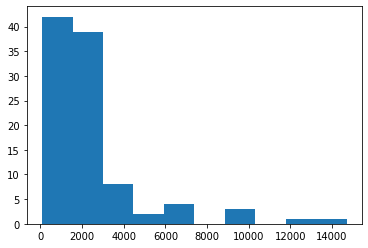

85.48581761660635


In [31]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data)
plt.show()
print(min(data))

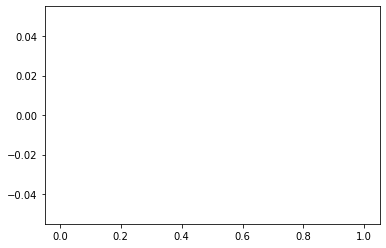

85.48581761660635


In [32]:
n, bins, patches = plt.hist([i for i in data if i<1.0])
plt.show()
print(min(data))

In [33]:
np.sort(data)[0:10]

array([ 85.48581762, 103.89720496, 174.41470918, 174.89856734,
       213.42903171, 332.81794058, 356.1825381 , 367.05870914,
       417.67832056, 478.4165371 ])

## DW

In [31]:
h_b_DW = 0.5*(p*p + (m*q + g*(q*q + mu*mu))**2)
h_f_DW = -0.5*(m+2*g*q)#[bdag,b]

In [32]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**2, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([ 0.91503687,  0.95899787,  3.21053807,  3.29031775,  7.00690424,
        7.12497247, 21.36752081, 25.12571192])

In [33]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**3, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([ 0.89308263,  0.89398305,  2.7445775 ,  2.75305657,  4.94585242,
        5.14085855,  8.30667934,  8.70004802, 13.31161275, 14.50467148])

In [34]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**4, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([0.89163849, 0.8916501 , 2.73421059, 2.73432506, 4.84645895,
       4.84793798, 7.18775479, 7.19586103, 9.75001443, 9.77982411])

In [35]:
dw_data=fill_vqe_dict(h_b_DW,h_f_DW, {m:1, g:1, mu: 1},[2**i for i in range(1,6)])
print(latex_vqe_table(dw_data))

2 & 1.08e+00 & 1.08e+00 \\ 
4 & 9.15e-01 & 9.15e-01 \\ 
8 & 8.93e-01 & 8.93e-01 \\ 
16 & 8.92e-01 & 8.94e-01 \\ 
32 & 8.92e-01 & 8.95e-01 \\ 



In [24]:
min(np.linalg.eig(getMatrix(hamDW.pauliStrings))[0])

(0.9150368745234885+0j)

In [36]:
from src.qiskit_utilities import *

obsDWHAM = pauli_string_to_op(hamDW.pauliStrings)

result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)

(1.0951884052605132+0j)


array([0.89163849, 0.8916501 , 2.73421059, 2.73432506, 4.84645895,
       4.84793798, 7.18775479, 7.19586103, 9.75001443, 9.77982411])

In [57]:
data = [] 

for i in range(0,200):
    result = vqe.compute_minimum_eigenvalue(obsDWHAM)
    data.append(result.eigenvalue.real)

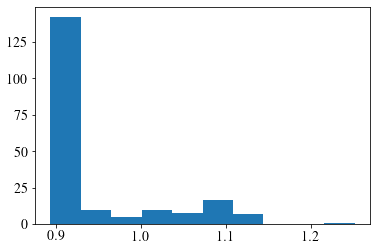

0.8933244311073774


In [58]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data)
plt.show()
print(min(data))

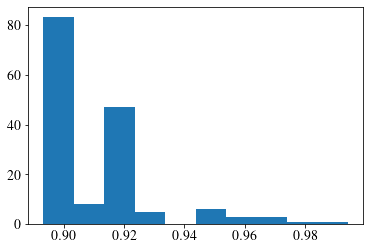

In [60]:
n, bins, patches = plt.hist([i for i in data if i<1.0])
plt.show()

In [26]:
ovec=vqe.get_optimal_vector()

<ipython-input-26-57588e3914d0>:1: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  ovec=vqe.get_optimal_vector()


In [27]:
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

{'000': 2.3286164616435062e-07,
 '001': 0.9308631200954977,
 '010': 3.3489621537576535e-09,
 '011': 0.02522975095438438,
 '100': 1.0025483874937313e-08,
 '101': 0.040498411502067,
 '110': 5.983480190999407e-10,
 '111': 0.0034084706136112606}

In [28]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.9150373521469856+0j)


{'000': 8.073637819672949e-07,
 '001': 0.9308282553503109,
 '010': 2.4662794928827658e-08,
 '011': 0.02524028592482414,
 '100': 3.5224547571854214e-08,
 '101': 0.04051712341810499,
 '110': 3.184555735469795e-09,
 '111': 0.003413464871079842}

In [29]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.9150566236540667+0j)


{'000': 6.001019895139936e-06,
 '001': 0.9308511027232788,
 '010': 3.8342875630128493e-07,
 '011': 0.025242013339559208,
 '100': 1.5863500285475468e-07,
 '101': 0.04049166268451669,
 '110': 2.0833487661717596e-07,
 '111': 0.0034084698341147234}

In [30]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.958999598759493+0j)


{'000': 0.6831652668751452,
 '001': 1.368271064476127e-06,
 '010': 0.006877669383093812,
 '011': 7.380283086148149e-09,
 '100': 0.3062737829086776,
 '101': 6.60748695841144e-07,
 '110': 0.0036811159798478157,
 '111': 1.284531923240483e-07}

In [31]:
print(vqe.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: 
Qiskit Terra version: 0.18.3
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_probs', 'save_probs_ket', 'save_state', 'save_statevector', 'set_statevector'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': 2, 'optimization_level': None}
RunConfig(shots=1, max_credits=10, seed_simulator=2)
{'timeout': None}
{}
{}
Measur

In [32]:
data = [] 

for i in range(0,200):
    result = vqe.compute_minimum_eigenvalue(obsDWHAM)
    data.append(result.eigenvalue.real)

In [33]:
data

[0.9589996842592351,
 0.9589988550070294,
 0.9150370916020274,
 0.9589989543256704,
 0.9152321873255256,
 0.9589991589509848,
 0.9589982205992242,
 0.9589985314152216,
 0.9150379485320339,
 0.9150397645492373,
 0.9589985749241112,
 0.9158879994116654,
 0.9196171357118081,
 0.9150371928680866,
 0.9150374735974568,
 0.9150371155432887,
 0.958998772041119,
 0.923974233456068,
 0.9590022358243386,
 0.9589989446678718,
 0.9150370486600578,
 0.9593796210321132,
 0.915037165210093,
 0.9150372564778442,
 0.9150372463868378,
 0.9150370163915896,
 0.9589991227268344,
 0.923984548301175,
 0.9150369895711731,
 0.9223103532396554,
 0.915037690589132,
 0.9606013401634718,
 0.9589985323432968,
 0.9589981893331796,
 0.9150371242220745,
 0.9589980926236715,
 0.9621209472673024,
 0.9150369659502577,
 0.9150372312947825,
 0.9177030741769233,
 0.9589982519213868,
 0.9589983816871387,
 0.9150370677977978,
 0.959000926208387,
 0.9150376453154834,
 0.9980125537138819,
 0.9150370964766137,
 0.9179232779207932

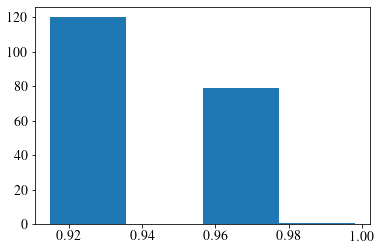

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data, 4)
plt.show()